# HPA Usage
Pesquisa por código no Github, buscando por arquivos que contenham definições de HPA (HorizontalPodAutoscaler).

Filtra por repositórios com alguma relevância (número de estrelas) e apresenta estatísticas.

Os arquivos encontrados após o filtro são salvos no diretório `search_results`.

## Preparando o ambiente

In [73]:
import os
import glob
import time
import re
import json
import requests
import yaml
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError, HTTP404NotFoundError, HTTP403ForbiddenError
import fastcore
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('bmh')

import utils

In [2]:
config = {
  **os.environ,
  **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])

In [3]:
gh_limit = github.rate_limit.get()

print(int(datetime.timestamp(datetime.now())), datetime.now().replace(microsecond=0))
print(gh_limit['resources']['core']['reset'], datetime.fromtimestamp(gh_limit['resources']['core']['reset']))
display(gh_limit['resources'])

1740511616 2025-02-25 16:26:56
1740515150 2025-02-25 17:25:50


```json
{ 'actions_runner_registration': { 'limit': 10000,
                                   'remaining': 10000,
                                   'reset': 1740515150,
                                   'used': 0},
  'audit_log': { 'limit': 1750,
                 'remaining': 1750,
                 'reset': 1740515150,
                 'used': 0},
  'audit_log_streaming': { 'limit': 15,
                           'remaining': 15,
                           'reset': 1740515150,
                           'used': 0},
  'code_scanning_autofix': { 'limit': 10,
                             'remaining': 10,
                             'reset': 1740511610,
                             'used': 0},
  'code_scanning_upload': { 'limit': 1000,
                            'remaining': 1000,
                            'reset': 1740515150,
                            'used': 0},
  'code_search': {'limit': 10, 'remaining': 10, 'reset': 1740511610, 'used': 0},
  'core': {'limit': 5000, 'remaining': 5000, 'reset': 1740515150, 'used': 0},
  'dependency_snapshots': { 'limit': 100,
                            'remaining': 100,
                            'reset': 1740511610,
                            'used': 0},
  'graphql': {'limit': 5000, 'remaining': 5000, 'reset': 1740515150, 'used': 0},
  'integration_manifest': { 'limit': 5000,
                            'remaining': 5000,
                            'reset': 1740515150,
                            'used': 0},
  'scim': {'limit': 15000, 'remaining': 15000, 'reset': 1740515150, 'used': 0},
  'search': {'limit': 30, 'remaining': 30, 'reset': 1740511610, 'used': 0},
  'source_import': { 'limit': 100,
                     'remaining': 100,
                     'reset': 1740511610,
                     'used': 0}}
```

## Definindo Funções Principais

In [3]:
def wait_for_reset(resource):
  limit = github.rate_limit.get()['resources'][resource]
  reset_time = datetime.fromtimestamp(limit['reset'])
  print(f"Waiting for {resource} until {reset_time}")
  now = datetime.today().replace(microsecond=0)
  if limit['remaining'] <= 1:
    sleep_duration = reset_time - now
    if sleep_duration.total_seconds() < 0:
      sleep_duration = timedelta(seconds=60)
    print(f"Waiting for {sleep_duration.total_seconds()} seconds")
    time.sleep(sleep_duration.total_seconds())

def search_code_hpa():
  """
  Realiza a pesquisa por arquivos de código contendo definição de um HPA ("kind: HorizontalPodAutoscaler")
  
  Por limitação da API, a cada pesquisa, um máximo de 1000 itens será retornado.
  """
  result_items = []
  page = 1

  # search_result acumula cada página da pesquisa
  search_result = None

  # Carrega as páginas da pesquisa
  while search_result is None or len(result_items) < search_result['total_count']:
    wait_for_reset('code_search')
    print(f"Carregando página {page}")
    time.sleep(1)
    try:
      search_result = github.search.code(q='"kind: HorizontalPodAutoscaler" language:yaml', per_page=100, page=page)
      result_items.extend(search_result['items'])
      page += 1
    except HTTP422UnprocessableEntityError as e:
      return result_items


def get_repo_details(row):
  wait_for_reset('core')
  name_parts = re.split(r'/', row['repo_name'])
  
  try:
    repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  except HTTP403ForbiddenError:
    print("Limit reached")
    wait_for_reset('core')
    repo_details = github.repos.get(owner=name_parts[0], repo=name_parts[1])
  except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
    return {
      'stargazers_count': None,
      'created_at': None,
      'pushed_at': None
    }
  
  return {
    'stargazers_count': repo_details['stargazers_count'],
    'created_at': repo_details['created_at'],
    'pushed_at': repo_details['pushed_at']
  }

def get_file_commit(row):
  wait_for_reset('core')
  name_parts = re.split(r'/', row['repo_name'])

  try:
    commits = github.repos.list_commits(owner=name_parts[0], repo=name_parts[1], path=row['file_path'], per_page=1)
  except HTTP403ForbiddenError:
    print("Limit reached")
    wait_for_reset('core')
    commits = github.repos.list_commits(owner=name_parts[0], repo=name_parts[1], path=row['file_path'], per_page=1)
  except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
    return {
      'file_committed_at': None,
      'message': None
    }
  
  return {
      'file_committed_at': commits[0]['commit']['author']['date'],
      'message': commits[0]['commit']['message']
    }


def extract_hpa(yaml_content):
  hpa_list = []
  for doc in yaml_content:
    if isinstance(doc, dict) and doc.get('kind') == "HorizontalPodAutoscaler":
      hpa_list.append(doc)
  return hpa_list


def download_hpa_spec(item):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')

  print(f"Downloading {item['url']}")
  response = requests.get(item['url'])
  if response.status_code == 200:

    # Remove marcações de template Helm
    clean_text = re.sub(r'{{-.*?}}', '', response.text)
    clean_text = re.sub(r'{{.*?}}', 'helm_command', clean_text)

    yaml_content = list(yaml.safe_load_all(clean_text))
    hpa_content = extract_hpa(yaml_content)
    if hpa_content is None:
      return

    target_path = os.path.join("search_results", item['repo_name'], item['file_path'])
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    
    with open(target_path, 'w') as file:
      file.write(yaml.dump_all(hpa_content))
  else:
    print(f"Loading {url} returned {response.status_code}")


def download_file(url, repo_name, file_path):
  if not os.path.isdir('search_results'):
    os.mkdir('search_results')
  
  response = requests.get(url.replace('/blob/', '/raw/'))
  if response.status_code == 200:
    target_path = os.path.join("search_results", repo_name, file_path)
    target_dir = os.path.dirname(target_path)
    os.makedirs(target_dir, exist_ok=True)
    with open(target_path, 'w') as file:
      file.write(response.text)
  else:
    print(f'Loading {url} returned {response.status_code}')
    

# Realiza a Pesquisa

In [55]:
search_items = []
result_items = search_code_hpa()
for item in result_items:
  search_items.append({
    'repo_name': item['repository']['full_name'],
    'file_path': item['path'],
    'url': item['html_url']
  })


Carregando página 1
Carregando página 2
Carregando página 3
Carregando página 4
Carregando página 5
Carregando página 6
Carregando página 7
Carregando página 8
Carregando página 9
Carregando página 10
Carregando página 11


In [56]:
items = pd.DataFrame(search_items)

display(items)
print(f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")


,repo_name,file_path,url
0,learnk8s/spring-boot-k8s-hpa,kube/hpa.yaml,https://github.com/learnk8s/spring-boot-k8s-hp...
1,krestomatio/moodle-operator,watches.yaml,https://github.com/krestomatio/moodle-operator...
2,ChandanTeekinavar/flask-mongo_db,hpa.yml,https://github.com/ChandanTeekinavar/flask-mon...
3,giel/cka_cursus,deployments/hpa-autoscaler.yaml,https://github.com/giel/cka_cursus/blob/ce2010...
4,jwdavis/k8s-demo-app,deploy.yaml,https://github.com/jwdavis/k8s-demo-app/blob/4...
...,...,...,...
995,prashanthgrebel/k8s,hpa/Hpa-autoscal.yml,https://github.com/prashanthgrebel/k8s/blob/49...
996,agabhinav/learnk8s,hpa/hpademo-yaml/hpademo-hpa.yaml,https://github.com/agabhinav/learnk8s/blob/098...
997,BAE-JI-WANG/btc-k8s,k8s-example-yaml/k8s-project/yamls/petclinic-w...,https://github.com/BAE-JI-WANG/btc-k8s/blob/72...
998,chatwoot/charts,charts/chatwoot/templates/worker-hpa.yaml,https://github.com/chatwoot/charts/blob/f09d92...


Encontrados 1000 arquivos em 894 repositórios


## Salva Fase 1 da Pesquisa

In [45]:
utils.save_results(items)

## Carrega todas as Pesquisas Anteriores

In [69]:
items = utils.load_results()

print(f"Encontrados {items.shape[0]} arquivos em {len(items['repo_name'].unique())} repositórios")

Encontrados 4992 arquivos em 3630 repositórios


## Dados adicionais
### Número de Estrelas

In [77]:
# Usando Parallel para buscar utilizando jobs em paralelo

repos_details = Parallel(n_jobs=32)(
  delayed(get_repo_details)(row) for _, row in items.iterrows()
)

display(repos_details)


/home/humbertofraga/local/hpa_usage/.venv/lib/python3.13/site-packages/joblib/parallel.py:1817: UserWarning: 64 tasks which were still being processed by the workers have been cancelled. You could benefit from adjusting the input task iterator to limit unnecessary computation time.
  warnings.warn(msg)


[{'stargazers_count': 0,
  'created_at': '2023-11-28T17:34:39Z',
  'pushed_at': '2024-01-15T09:15:33Z'},
 {'stargazers_count': 2,
  'created_at': '2022-05-02T18:37:39Z',
  'pushed_at': '2023-08-01T07:52:38Z'},
 {'stargazers_count': 4,
  'created_at': '2023-04-17T06:54:36Z',
  'pushed_at': '2025-02-14T07:10:42Z'},
 {'stargazers_count': 0,
  'created_at': '2023-08-03T03:34:49Z',
  'pushed_at': '2023-08-03T05:39:07Z'},
 {'stargazers_count': 0,
  'created_at': '2022-12-21T08:50:49Z',
  'pushed_at': '2023-01-21T16:25:12Z'},
 {'stargazers_count': 1,
  'created_at': '2024-06-15T05:01:30Z',
  'pushed_at': '2024-06-15T13:25:39Z'},
 {'stargazers_count': 0,
  'created_at': '2020-12-17T13:12:06Z',
  'pushed_at': '2021-07-06T08:58:38Z'},
 {'stargazers_count': 24,
  'created_at': '2016-05-09T21:23:58Z',
  'pushed_at': '2025-02-22T00:08:58Z'},
 {'stargazers_count': 24,
  'created_at': '2016-05-09T21:23:58Z',
  'pushed_at': '2025-02-22T00:08:58Z'},
 {'stargazers_count': 24,
  'created_at': '2016-05-09

In [81]:
df_details = pd.DataFrame(repos_details)
display(df_details.info())

display(df_details[df_details['stargazers_count'].isna()])



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   stargazers_count  4987 non-null   float64
 1   created_at        4987 non-null   object 
 2   pushed_at         4987 non-null   object 
dtypes: float64(1), object(2)
memory usage: 117.1+ KB


None

,stargazers_count,created_at,pushed_at
1344,NaN,None,None
3587,NaN,None,None
3843,NaN,None,None
3844,NaN,None,None
4485,NaN,None,None


### Commit do arquivo

In [87]:
wait_for_reset('core')

paths_committed_at = Parallel(n_jobs=16)(
  delayed(get_file_commit)(row) for _, row in items.iterrows()
)

# paths_committed_at = [get_file_commit(item['repo_name'], item['file_path']) for item in repo_paths]


Waiting for core until 2025-02-23 22:06:15
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:16
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for core until 2025-02-23 22:06:17
Waiting for

/home/humbertofraga/local/hpa_usage/.venv/lib/python3.13/site-packages/joblib/parallel.py:1817: UserWarning: 32 tasks which were still being processed by the workers have been cancelled. You could benefit from adjusting the input task iterator to limit unnecessary computation time.
  warnings.warn(msg)


In [91]:
df_committed_at = pd.DataFrame(paths_committed_at)
display(df_committed_at.info())

display(df_committed_at[df_committed_at['message'].isna()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4992 entries, 0 to 4991
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_committed_at  4987 non-null   object
 1   message            4987 non-null   object
dtypes: object(2)
memory usage: 78.1+ KB


None

,file_committed_at,message
1344,None,None
3587,None,None
3843,None,None
3844,None,None
4485,None,None


In [92]:
items_details = items.join([df_details, df_committed_at])

display(items_details)

# Há alguns itens que representam repositórios que não existem mais (HTTP404NotFoundError)
display(items_details[items_details['stargazers_count'].isna()])

,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
0,01-edu/orchestrator,manifests/inventory-app.yaml,https://github.com/01-edu/orchestrator/blob/87...,0.0,2023-11-28T17:34:39Z,2024-01-15T09:15:33Z,2024-01-09T14:19:25Z,feat(secrets): move secrets to kustomization.yaml
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02T18:37:39Z,2023-08-01T07:52:38Z,2022-05-03T06:56:57Z,Añadidas las plantillas en diferentes tecnologías
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17T06:54:36Z,2025-02-14T07:10:42Z,2023-04-26T19:25:23Z,Migrates Element Chart - Changes some Ingress ...
3,0nebody/charts,stable/benth/templates/hpa.yaml,https://github.com/0nebody/charts/blob/1ed4ad1...,0.0,2023-08-03T03:34:49Z,2023-08-03T05:39:07Z,2023-08-03T04:47:13Z,add benth chart
4,0xhappyboy/react-template,market-template-1/hokusai/staging.yml,https://github.com/0xhappyboy/react-template/b...,0.0,2022-12-21T08:50:49Z,2023-01-21T16:25:12Z,2023-01-21T16:25:05Z,update : update
...,...,...,...,...,...,...,...,...
4987,zquestz/reapers.cash,kube/reapers-autoscale.yml,https://github.com/zquestz/reapers.cash/blob/7...,1.0,2022-01-08T04:54:17Z,2024-11-14T00:06:41Z,2022-01-08T04:55:05Z,Reapers skeleton
4988,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/7830475ad18...,1.0,2024-05-01T12:56:19Z,2024-11-03T16:43:53Z,2024-05-01T13:19:22Z,feat: adding trainticket application
4989,zuc/helm-charts,charts/outline/templates/hpa.yaml,https://github.com/zuc/helm-charts/blob/d28af2...,1.0,2020-06-22T15:09:56Z,2021-05-14T19:57:31Z,2020-06-23T10:25:30Z,test
4990,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08T07:59:57Z,2025-02-17T06:20:44Z,2024-01-30T07:41:10Z,use maven build native image


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
1344,agntcy/dir,install/charts/dir/apiserver/templates/hpa.yaml,https://github.com/agntcy/dir/blob/6a161519d43...,NaN,None,None,None,None
3587,nk1752/called-caller,flex-gateway/templates/deployment-hpa.yaml,https://github.com/nk1752/called-caller/blob/9...,NaN,None,None,None,None
3843,prompted365/sunlink,sunlink-api-hpa.yaml,https://github.com/prompted365/sunlink/blob/c2...,NaN,None,None,None,None
3844,prompted365/sunlink,sunlink-api-hpa.yaml,https://github.com/prompted365/sunlink/blob/19...,NaN,None,None,None,None
4485,stzou/Sandbox,HPA/hpa.yaml,https://github.com/stzou/Sandbox/blob/5889e9c9...,NaN,None,None,None,None


In [ ]:
# Removendo estes itens
items_details.dropna(subset=['stargazers_count'], inplace=True, ignore_index=True)

# Salva DataFrame completo em um CSV
items_details.to_csv(f"partial_results/{datetime.now().replace(microsecond=0).isoformat()}-phase2.csv", ignore_index=True)

In [115]:
items_details = utils.load_phase2_results()

print(f"{items_details['repo_name'].unique().shape[0]} repositórios únicos")

items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])
display(items_details)

partial_results/2025-02-23T21:14:45-phase2.csv
3626 repositórios únicos


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message
0,01-edu/orchestrator,manifests/inventory-app.yaml,https://github.com/01-edu/orchestrator/blob/87...,0.0,2023-11-28 17:34:39+00:00,2024-01-15 09:15:33+00:00,2024-01-09T14:19:25Z,feat(secrets): move secrets to kustomization.yaml
1,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02 18:37:39+00:00,2023-08-01 07:52:38+00:00,2022-05-03T06:56:57Z,Añadidas las plantillas en diferentes tecnologías
2,0hlov3/charts,charts/element-web/templates/hpa.yaml,https://github.com/0hlov3/charts/blob/daca391f...,4.0,2023-04-17 06:54:36+00:00,2025-02-14 07:10:42+00:00,2023-04-26T19:25:23Z,Migrates Element Chart - Changes some Ingress ...
3,0nebody/charts,stable/benth/templates/hpa.yaml,https://github.com/0nebody/charts/blob/1ed4ad1...,0.0,2023-08-03 03:34:49+00:00,2023-08-03 05:39:07+00:00,2023-08-03T04:47:13Z,add benth chart
4,0xhappyboy/react-template,market-template-1/hokusai/staging.yml,https://github.com/0xhappyboy/react-template/b...,0.0,2022-12-21 08:50:49+00:00,2023-01-21 16:25:12+00:00,2023-01-21T16:25:05Z,update : update
...,...,...,...,...,...,...,...,...
4982,zquestz/reapers.cash,kube/reapers-autoscale.yml,https://github.com/zquestz/reapers.cash/blob/7...,1.0,2022-01-08 04:54:17+00:00,2024-11-14 00:06:41+00:00,2022-01-08T04:55:05Z,Reapers skeleton
4983,zsmn/k8scd,k8s/config/istio/istio-ingress.yaml,https://github.com/zsmn/k8scd/blob/7830475ad18...,1.0,2024-05-01 12:56:19+00:00,2024-11-03 16:43:53+00:00,2024-05-01T13:19:22Z,feat: adding trainticket application
4984,zuc/helm-charts,charts/outline/templates/hpa.yaml,https://github.com/zuc/helm-charts/blob/d28af2...,1.0,2020-06-22 15:09:56+00:00,2021-05-14 19:57:31+00:00,2020-06-23T10:25:30Z,test
4985,zuisong/vertx-server-push,k8s.yml,https://github.com/zuisong/vertx-server-push/b...,3.0,2021-03-08 07:59:57+00:00,2025-02-17 06:20:44+00:00,2024-01-30T07:41:10Z,use maven build native image


In [116]:
print("Todos os resultados")
print(items_details['stargazers_count'].describe())

min_stars = 10
print(f"\nMínimo de {min_stars} estrelas")
filter_min_stars = items_details[items_details['stargazers_count'] > min_stars]
print(filter_min_stars['stargazers_count'].describe())

print("\nPercentil > 0.9 estrelas")
filter_outliers_items = items_details[items_details['stargazers_count'] >= items_details['stargazers_count'].quantile(0.90)]
print(filter_outliers_items['stargazers_count'].describe())


Todos os resultados
count     4987.000000
mean       184.683577
std       1413.405707
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max      29519.000000
Name: stargazers_count, dtype: float64

Mínimo de 10 estrelas
count      901.000000
mean      1018.426193
std       3196.557440
min         11.000000
25%         28.000000
50%         53.000000
75%        233.000000
max      29519.000000
Name: stargazers_count, dtype: float64

Percentil > 0.9 estrelas
count      534.000000
mean      1700.985019
std       4013.429033
min         51.000000
25%         87.250000
50%        172.000000
75%        803.250000
max      29519.000000
Name: stargazers_count, dtype: float64


In [117]:
print(f"{filter_min_stars['repo_name'].unique().shape[0]} repositórios únicos")

380 repositórios únicos


# Analisando número de estrelas

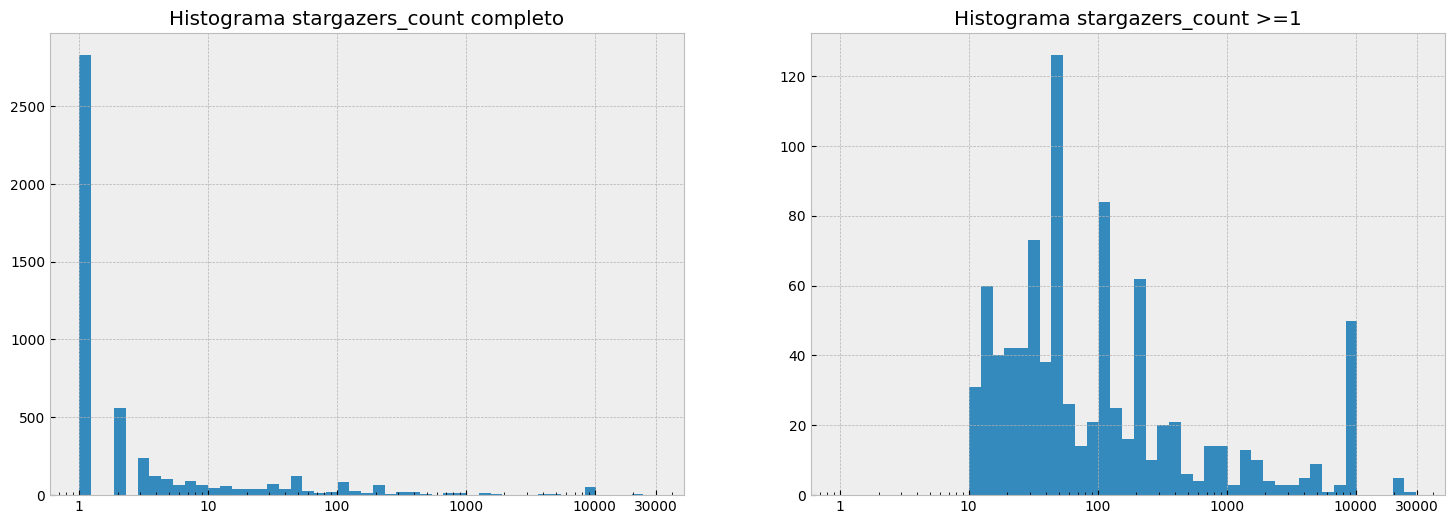

In [118]:
plt.style.use('bmh')
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_full = items_details['stargazers_count']
data_filter = filter_min_stars['stargazers_count']

bins_full = np.logspace(0, np.log10(data_full.max() + 1), 50)
bins_filter = np.logspace(0, np.log10(data_filter.max() + 1), 50)

ticks = [1, 10, 100, 1000, 10000, 30000]

axes[0].hist(data_full + 1, bins=bins_full)
axes[0].set_xscale('log')
axes[0].set_xticks(ticks, ticks)
axes[0].set_title("Histograma stargazers_count completo")

axes[1].hist(data_filter + 1, bins=bins_filter)
axes[1].set_xscale('log')
axes[1].set_xticks(ticks, ticks)
axes[1].set_title("Histograma stargazers_count >=1")

plt.show()

# Analisando created_at e pushed_at

In [119]:
created_at = pd.to_datetime(items_details['created_at'])
pushed_at = pd.to_datetime(items_details['pushed_at'])

print(f"Repositório criado a mais tempo:\t{created_at.min()}\n\
Repositório criado a menos tempo:\t{created_at.max()}")

print(f"Repositório atualizado a mais tempo:\t{pushed_at.min()}\n\
Repositório atualizado a menos tempo:\t{pushed_at.max()}")

Repositório criado a mais tempo:	2011-10-27 05:58:15+00:00
Repositório criado a menos tempo:	2025-02-22 19:05:06+00:00
Repositório atualizado a mais tempo:	2015-12-01 23:05:53+00:00
Repositório atualizado a menos tempo:	2025-02-23 14:53:43+00:00


In [120]:
items_details['life_span'] = items_details['pushed_at'] - items_details['created_at']

display(items_details[items_details['life_span']==items_details['life_span'].min()])

display(items_details['life_span'].describe())

min_days = 180
print(f"\nMínimo de {min_days} dias")
filter_min_days = items_details[items_details['life_span'].dt.days > min_days]
print(filter_min_days['life_span'].describe())

print("\nPercentil > 0.9 mais longevos")
filter_outliers_life_span = items_details[items_details['life_span'] >= items_details['life_span'].quantile(0.90)]
print(filter_outliers_life_span['life_span'].describe())

,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message,life_span
4957,zccfzcc/docker-images,prometheus/production/example-app/example-app-...,https://github.com/zccfzcc/docker-images/blob/...,0.0,2019-09-18 02:54:06+00:00,2019-04-24 09:33:37+00:00,2019-03-08T04:13:49Z,prometheus,-147 days +06:39:31


count                           4987
mean     531 days 23:21:09.814918792
std      736 days 15:30:44.459735536
min              -147 days +06:39:31
25%                 14 days 02:05:19
50%                153 days 22:08:06
75%         820 days 12:31:31.500000
max               4621 days 20:44:22
Name: life_span, dtype: object


Mínimo de 180 dias
count                            2404
mean     1062 days 00:23:29.827371056
std       762 days 02:07:05.446161128
min                 182 days 02:06:00
25%          430 days 09:18:30.750000
50%                 848 days 02:29:08
75%         1490 days 14:32:51.750000
max                4621 days 20:44:22
Name: life_span, dtype: object

Percentil > 0.9 mais longevos
count                             499
mean     2251 days 08:16:44.967935904
std       571 days 00:44:36.085458976
min                1668 days 07:12:23
25%                1771 days 11:00:33
50%                2065 days 08:54:21
75%                2586 days 15:35:53
max                4621 days 20:44:22
Name: life_span, dtype: object


In [121]:
display(items_details['pushed_at'].describe())

limit_oldest_pushed_at = (datetime.today() - timedelta(days=360)).replace(hour=0, minute=0, second=0, microsecond=0, tzinfo=ZoneInfo('GMT'))
print(f"\npushed_at mais recentes do que {limit_oldest_pushed_at}")
filter_newer_pushed_at = items_details[items_details['pushed_at'] > limit_oldest_pushed_at]
print(filter_newer_pushed_at['pushed_at'].describe())

print("\nPercentil >= 0.9 mais recentes")
filter_outliers_life_span = items_details[items_details['pushed_at'] >= items_details['pushed_at'].quantile(0.90)]
print(filter_outliers_life_span['pushed_at'].describe())

count                                   4987
mean     2024-01-23 22:58:56.266492928+00:00
min                2015-12-01 23:05:53+00:00
25%                2023-08-02 05:36:29+00:00
50%                2024-08-27 09:11:21+00:00
75%                2025-02-06 12:46:47+00:00
max                2025-02-23 14:53:43+00:00
Name: pushed_at, dtype: object


pushed_at mais recentes do que 2024-03-02 00:00:00+00:00
count                                   3220
mean     2024-11-22 00:28:00.570186496+00:00
min                2024-03-02 14:24:18+00:00
25%      2024-09-10 13:40:55.750000128+00:00
50%         2024-12-23 09:02:14.500000+00:00
75%                2025-02-20 18:11:07+00:00
max                2025-02-23 14:53:43+00:00
Name: pushed_at, dtype: object

Percentil >= 0.9 mais recentes
count                                    520
mean     2025-02-22 17:58:50.075000064+00:00
min                2025-02-22 00:06:30+00:00
25%                2025-02-22 05:27:15+00:00
50%                2025-02-22 16:01:24+00:00
75%                2025-02-23 06:45:56+00:00
max                2025-02-23 14:53:43+00:00
Name: pushed_at, dtype: object


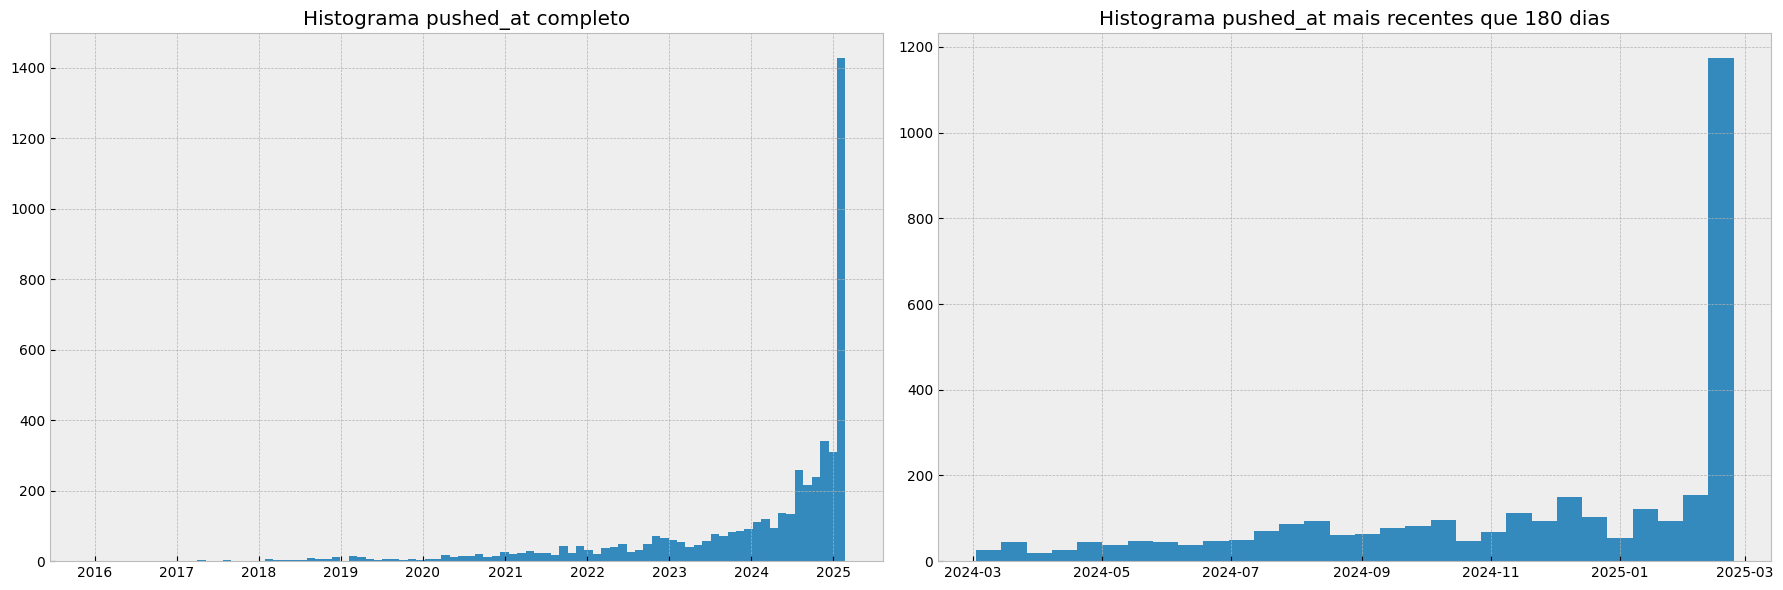

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

data_full = items_details['pushed_at']
data_filter = filter_newer_pushed_at['pushed_at']

# bins_full = np.logspace(0, np.log10(data_full.max() + 1), 50)
# bins_filter = np.logspace(0, np.log10(data_filter.max() + 1), 50)

ticks = [1, 10, 100, 1000, 10000, 30000]

axes[0].hist(data_full, bins=90)
# axes[0].set_xticks(ticks, ticks)
axes[0].set_title("Histograma pushed_at completo")

axes[1].hist(data_filter, bins=30)
# axes[1].set_xticks(ticks, ticks)
axes[1].set_title("Histograma pushed_at mais recentes que 180 dias")

plt.tight_layout()
plt.show()

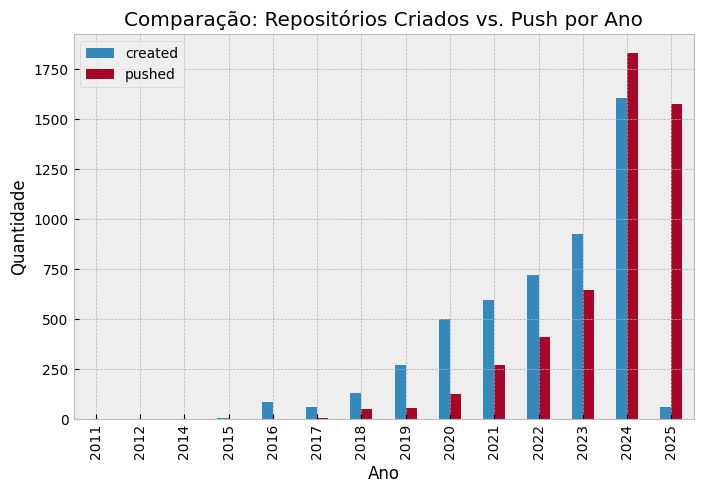

In [123]:
items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])

items_details['created_year'] = items_details['created_at'].dt.year
items_details['pushed_year'] = items_details['pushed_at'].dt.year

created_year_count = items_details.groupby('created_year')['repo_name'].count()
pushed_year_count = items_details.groupby('pushed_year')['repo_name'].count()

df_anos = pd.DataFrame({
    'created': created_year_count,
    'pushed': pushed_year_count
})

df_anos.plot(kind='bar', figsize=(8,5))
plt.title('Comparação: Repositórios Criados vs. Push por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.show()


# Filtrando por Número de Estrelas e por Último Commit

In [124]:
filtered_items = items_details[(items_details['stargazers_count'] > min_stars) & (items_details['pushed_at'] > limit_oldest_pushed_at)]

print(filtered_items.info())

display(filtered_items)

<class 'pandas.core.frame.DataFrame'>
Index: 764 entries, 7 to 4956
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   repo_name          764 non-null    object             
 1   file_path          764 non-null    object             
 2   url                764 non-null    object             
 3   stargazers_count   764 non-null    float64            
 4   created_at         764 non-null    datetime64[ns, UTC]
 5   pushed_at          764 non-null    datetime64[ns, UTC]
 6   file_committed_at  764 non-null    object             
 7   message            764 non-null    object             
 8   life_span          764 non-null    timedelta64[ns]    
 9   created_year       764 non-null    int32              
 10  pushed_year        764 non-null    int32              
dtypes: datetime64[ns, UTC](2), float64(1), int32(2), object(5), timedelta64[ns](1)
memory usage: 65.7+ KB
None


,repo_name,file_path,url,stargazers_count,created_at,pushed_at,file_committed_at,message,life_span,created_year,pushed_year
7,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,24.0,2016-05-09 21:23:58+00:00,2025-02-22 00:08:58+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3210 days 02:45:00,2016,2025
8,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,24.0,2016-05-09 21:23:58+00:00,2025-02-22 00:08:58+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3210 days 02:45:00,2016,2025
9,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,24.0,2016-05-09 21:23:58+00:00,2025-02-22 00:08:58+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3210 days 02:45:00,2016,2025
10,18F/identity-dashboard,dockerfiles/application.yaml,https://github.com/18F/identity-dashboard/blob...,24.0,2016-05-09 21:23:58+00:00,2025-02-22 00:08:58+00:00,2024-12-17T20:05:37Z,fix reviewapp service providers in dbsetup ste...,3210 days 02:45:00,2016,2025
18,2gis/on-premise-helm-charts,charts/navi-restrictions/templates/hpa.yaml,https://github.com/2gis/on-premise-helm-charts...,12.0,2021-12-03 12:16:25+00:00,2025-02-21 12:33:30+00:00,2023-01-12T09:25:05Z,fix deprecated (#221),1176 days 00:17:05,2021,2025
...,...,...,...,...,...,...,...,...,...,...,...
4893,wundergraph/cosmo,helm/cosmo/charts/controlplane/templates/hpa.yaml,https://github.com/wundergraph/cosmo/blob/4553...,826.0,2023-08-23 09:31:29+00:00,2025-02-21 20:49:39+00:00,2023-08-23T09:42:46Z,chore: initial commit 🌟,548 days 11:18:10,2023,2025
4894,wundergraph/cosmo,helm/cosmo/charts/controlplane/templates/hpa.yaml,https://github.com/wundergraph/cosmo/blob/5ca5...,826.0,2023-08-23 09:31:29+00:00,2025-02-21 20:49:39+00:00,2023-08-23T09:42:46Z,chore: initial commit 🌟,548 days 11:18:10,2023,2025
4948,zabbix/zabbix-docker,kubernetes.yaml,https://github.com/zabbix/zabbix-docker/blob/7...,2475.0,2016-08-03 07:36:01+00:00,2025-02-21 07:03:49+00:00,2024-12-10T15:55:54Z,Prepare for Zabbix 7.2 release,3123 days 23:27:48,2016,2025
4953,zalando-incubator/kubernetes-on-aws,cluster/manifests/kubelet-summary-metrics/hpa....,https://github.com/zalando-incubator/kubernete...,625.0,2016-10-14 06:55:28+00:00,2025-02-22 06:47:12+00:00,2023-11-29T13:58:46Z,Add kubelet-summary-metrics proxy\n\nSigned-of...,3052 days 23:51:44,2016,2025


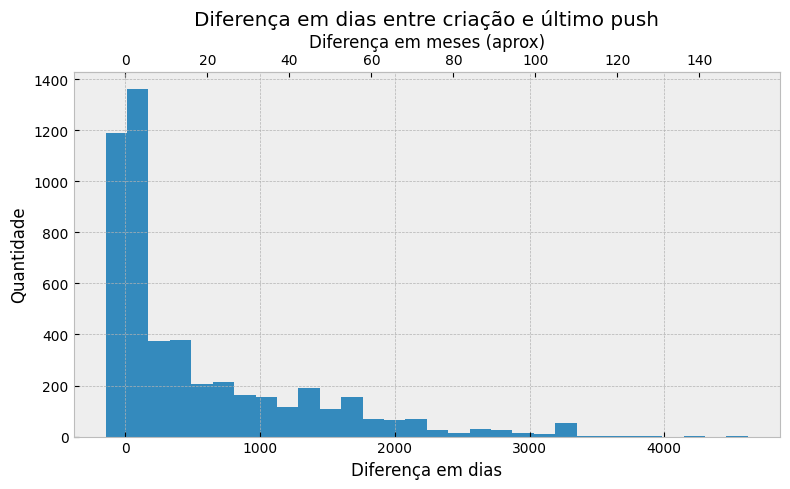

In [58]:
fig, ax = plt.subplots(figsize=(8,5))
n, bins, patches = ax.hist(items_details['life_span'].dt.days, bins=30)
ax.set_xlabel('Diferença em dias')
ax.set_ylabel('Quantidade')

def days_to_months(x):
  return x / 30.4375

def months_to_days(x):
  return x * 30.4375

secax_months = ax.secondary_xaxis('top', functions=(days_to_months, months_to_days))
secax_months.set_xlabel("Diferença em meses (aprox)")

plt.title('Diferença em dias entre criação e último push')
plt.tight_layout()
plt.show()

# Definindo corte de repositórios relevantes

In [84]:
filtered_items = filter_min_stars.sort_values(by=['stargazers_count'])
filtered_items

,repo_name,file_path,url,stargazers_count,created_at,pushed_at
0,0GiS0/tour-of-heroes-gitops-demos,helm/tour-of-heroes-chart/charts/api/templates...,https://github.com/0GiS0/tour-of-heroes-gitops...,2.0,2022-05-02T18:37:39Z,2023-08-01T07:52:38Z
4330,yokawasa/aksworkshop,examples/captureorder-hpa.yaml,https://github.com/yokawasa/aksworkshop/blob/5...,2.0,2019-04-21T15:25:13Z,2019-04-22T06:39:34Z
4229,visionhong/MLOps-DP,release_patterns/model_in_image_pattern/manife...,https://github.com/visionhong/MLOps-DP/blob/9e...,2.0,2022-09-02T08:04:41Z,2022-12-28T01:00:40Z
4205,vfarcic/what-devs-need-demo,helm/templates/hpa.yaml,https://github.com/vfarcic/what-devs-need-demo...,2.0,2021-10-02T22:09:47Z,2021-10-07T18:34:09Z
2354,imaginestack/kubelogic,kube-plugins/kubes-helm-charts/src/stable/ys10...,https://github.com/imaginestack/kubelogic/blob...,2.0,2023-05-23T01:43:40Z,2023-06-05T15:33:02Z
...,...,...,...,...,...,...
162,Budibase/budibase,charts/budibase/templates/automation-worker-se...,https://github.com/Budibase/budibase/blob/1328...,23483.0,2019-06-07T11:03:41Z,2025-02-21T16:49:21Z
164,Budibase/budibase,charts/budibase/templates/automation-worker-se...,https://github.com/Budibase/budibase/blob/1e97...,23483.0,2019-06-07T11:03:41Z,2025-02-21T16:49:21Z
2195,grafana/loki,production/helm/loki/templates/querier/hpa.yaml,https://github.com/grafana/loki/blob/8fd8697b9...,24684.0,2018-04-16T09:22:48Z,2025-02-21T20:47:10Z
4112,transloadit/uppy,packages/@uppy/companion/infra/kube/companion/...,https://github.com/transloadit/uppy/blob/ead58...,29517.0,2015-11-16T12:32:33Z,2025-02-17T14:09:27Z


In [27]:
def prepare_csv(item):
  owner_repo = re.split(pattern=r'/', string=item['repo_name'])
  return pd.Series({
    'owner': owner_repo[0],
    'repo': owner_repo[1],
    'path': item['file_path']
  })

csv_prepared = filter_min_stars.apply(prepare_csv, axis=1)
csv_prepared.to_csv('extract.csv')


In [168]:
urls = items['url'].tolist()
repo_names = items['repo_name'].tolist()
file_paths = items['file_path'].tolist()

Parallel(n_jobs=4)(
  delayed(download_file)(url, repo_name, file_path)
  for url, repo_name, file_path in zip(urls, repo_names, file_paths)
)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,